In [5]:
import csv
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from collections import defaultdict
import re

Some Important Functions

In [16]:
def extract_cwes(text):
    """Extract CWE-xxx patterns from arbitrary text"""
    if not text:
        return []
    return list({m.group(0).upper() for m in re.finditer(r"CWE-\d+", text)})

def clean_cwe(cwe):
    """Normalize CWE string to format 'CWE-xxx'"""
    cwe = str(cwe).strip().upper()
    cwe = cwe.split(":")[0].split()[0]  # remove trailing colon or description
    if not cwe.startswith("CWE-") and cwe.isdigit():
        cwe = "CWE-" + cwe
    return cwe

Converting all files to csv format

In [ ]:
folder = "."  # Folder containing the JSON and SARIF files
output_file = "final_findings.csv"

cwe_top_25 = {
    "CWE-79","CWE-787","CWE-89","CWE-352","CWE-22","CWE-125","CWE-78","CWE-416",
    "CWE-862","CWE-434","CWE-94","CWE-20","CWE-77","CWE-287","CWE-269","CWE-502",
    "CWE-200","CWE-863","CWE-918","CWE-119","CWE-476","CWE-798","CWE-190","CWE-400","CWE-306"
}

counts = defaultdict(int)

# For Semgrep
for f in os.listdir(folder):
    if f.startswith("semgrep_") and f.endswith(".json"):
        project = f.replace("semgrep_", "").replace(".json", "")
        with open(os.path.join(folder, f), "r", encoding="utf-8") as fp:
            data = json.load(fp)
        for res in data.get("results", []):
            meta = res.get("extra", {}).get("metadata", {})
            cwes = []
            if isinstance(meta.get("cwe"), list):
                cwes = [clean_cwe(c) for c in meta["cwe"]]
            elif isinstance(meta.get("cwe"), str):
                cwes = [clean_cwe(meta["cwe"])]
            else:
                cwes = [clean_cwe(c) for c in extract_cwes(json.dumps(res))]
            if not cwes:
                cwes = ["UNKNOWN"]
            for c in cwes:
                counts[(project, "Semgrep", c)] += 1

# For Bandit
for f in os.listdir(folder):
    if f.startswith("bandit_") and f.endswith(".json"):
        project = f.replace("bandit_", "").replace(".json", "")
        with open(os.path.join(folder, f), "r", encoding="utf-8") as fp:
            data = json.load(fp)
        for res in data.get("results", []):
            cwes = []
            if "cwe" in res:
                if isinstance(res["cwe"], dict):
                    cid = res["cwe"].get("id") or res["cwe"].get("name")
                    if cid: cwes = [clean_cwe(cid)]
                elif isinstance(res["cwe"], str):
                    cwes = [clean_cwe(res["cwe"])]
            if not cwes:
                cwes = [clean_cwe(c) for c in extract_cwes(json.dumps(res))]
            if not cwes:
                cwes = ["UNKNOWN"]
            for c in cwes:
                counts[(project, "Bandit", c)] += 1

# For CodeQL
for f in os.listdir(folder):
    if f.endswith(".sarif"):
        project = f.split("_")[0].lower()
        with open(os.path.join(folder, f), "r", encoding="utf-8") as fp:
            data = json.load(fp)
        for run in data.get("runs", []):
            rule_map = {rule.get("id"): rule for rule in run.get("tool", {}).get("driver", {}).get("rules", [])}
            for result in run.get("results", []):
                rule = rule_map.get(result.get("ruleId"), {})
                tags = rule.get("properties", {}).get("tags", [])
                cwes = [clean_cwe(t) for t in tags if isinstance(t, str) and t.upper().startswith("CWE-")]
                if not cwes:
                    cwes = [clean_cwe(c) for c in extract_cwes(json.dumps(result))]
                if not cwes:
                    cwes = ["UNKNOWN"]
                for c in cwes:
                    counts[(project, "CodeQL", c)] += 1

rows = []
for (project, tool, cwe), count in counts.items():
    rows.append({
        "Project_name": project,
        "Tool_name": tool,
        "CWE_ID": cwe,
        "Number_of_Findings": count,
        "Is_In_CWE_Top_25?": "Yes" if cwe in cwe_top_25 else "No"
    })

df = pd.DataFrame(rows)
df = df.sort_values(["Project_name", "Tool_name", "CWE_ID"])
df.to_csv(output_file, index=False)

print(f"Saved final CSV: {output_file}")
display(df.head(20))

Saved final CSV: final_findings.csv


,Project_name,Tool_name,CWE_ID,Number_of_Findings,Is_In_CWE_Top_25?
14,gunicorn,Bandit,UNKNOWN,291,No
18,gunicorn,CodeQL,UNKNOWN,99,No
4,gunicorn,Semgrep,CWE-319,33,No
11,gunicorn,Semgrep,CWE-326,1,No
9,gunicorn,Semgrep,CWE-327,2,No
5,gunicorn,Semgrep,CWE-353,4,No
10,gunicorn,Semgrep,CWE-706,3,No
6,gunicorn,Semgrep,CWE-79,1,Yes
8,gunicorn,Semgrep,CWE-798,1,Yes
7,gunicorn,Semgrep,CWE-95,1,No


##### Tool-level CWE Coverage Analysis

Tool-level CWE Top 25 Coverage:


,Tool_name,Detected_Top_25_CWEs,Coverage_Percent
0,Bandit,[],0.0
1,CodeQL,[],0.0
2,Semgrep,"[CWE-798, CWE-79, CWE-502, CWE-78]",16.0


/var/folders/3m/s02h4sgd74lg5s9ytbmcm02w0000gn/T/ipykernel_34386/2287754784.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coverage_df, x="Tool_name", y="Coverage_Percent", palette="viridis")


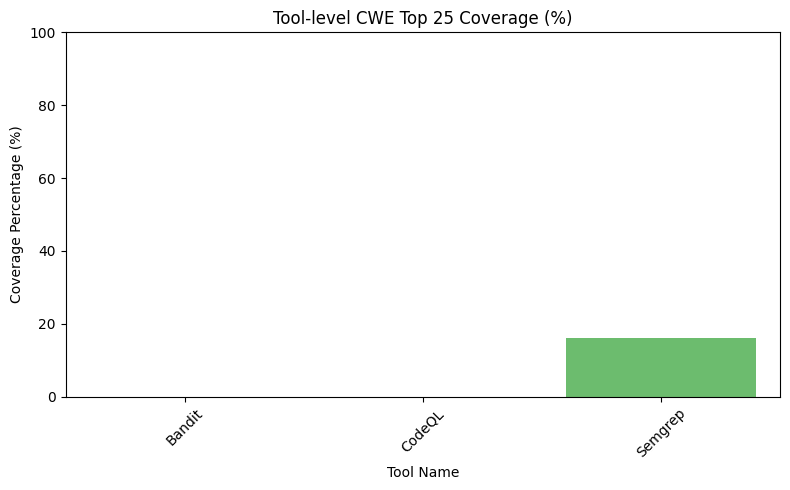

In [21]:
df = pd.read_csv("final_findings.csv")

tool_cwe_map = df.groupby("Tool_name")["CWE_ID"].apply(set)

# Compute Top 25 coverage for each tool
coverage_data = []
for tool, cwes in tool_cwe_map.items():
    detected_top_25 = [cwe for cwe in cwes if cwe in cwe_top_25]
    coverage_percent = (len(detected_top_25) / len(cwe_top_25)) * 100
    coverage_data.append({
        "Tool_name": tool,
        "Detected_Top_25_CWEs": detected_top_25,
        "Coverage_Percent": round(coverage_percent, 2)
    })

coverage_df = pd.DataFrame(coverage_data)
print("Tool-level CWE Top 25 Coverage:")
display(coverage_df)

# Visualising the data
plt.figure(figsize=(8, 5))
sns.barplot(data=coverage_df, x="Tool_name", y="Coverage_Percent", palette="viridis")
plt.title("Tool-level CWE Top 25 Coverage (%)")
plt.ylabel("Coverage Percentage (%)")
plt.ylim(0, 100)
plt.xlabel("Tool Name")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##### Pairwise Agreement (IoU) Analysis

In [23]:
tools = list(tool_cwe_map.keys())

iou_matrix = pd.DataFrame(index=tools, columns=tools, dtype=float)

for t1 in tools:
    for t2 in tools:
        set1, set2 = tool_cwe_map[t1], tool_cwe_map[t2]
        iou = len(set1 & set2) / len(set1 | set2) if len(set1 | set2) > 0 else 0
        iou_matrix.loc[t1, t2] = iou

print("Tool x Tool IoU Matrix:")
display(iou_matrix)

Tool x Tool IoU Matrix:


,Bandit,CodeQL,Semgrep
Bandit,1.0,1.0,0.0
CodeQL,1.0,1.0,0.0
Semgrep,0.0,0.0,1.0
